In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Для запуска графического ядра
import time

def time_matmul(x):
  start = time.time()
  for loop in range(100):
    tf.matmul(x, x)

  result = time.time()-start

  print("100 циклов: {:0.2f}ms".format(1000*result))

for i in range(2):
    # исполнение CPU
    print(" CPU работает:")
    with tf.device("CPU:0"):
      x = tf.random.uniform([1000, 1000])
      assert x.device.endswith("CPU:0")
      time_matmul(x)

    # исполнение на GPU #0 , если доступен
    if tf.config.experimental.list_physical_devices("GPU"):
      print(" какой GPU:")
      with tf.device("GPU:0"): # или GPU:1 , для 2х GPU, GPU:2 для 3х  и т.д.
        x = tf.random.uniform([1000, 1000])
        assert x.device.endswith("GPU:0")
        time_matmul(x)

 CPU работает:
100 циклов: 356.32ms
 какой GPU:
100 циклов: 367.58ms
 CPU работает:
100 циклов: 341.31ms
 какой GPU:
100 циклов: 6.01ms


In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, Flatten, LSTM,Conv1D,MaxPooling1D,Average
from sklearn.preprocessing import StandardScaler,MinMaxScaler


In [32]:
def make_data(data, xLen=12, split=0.8):
    data_all = np.array(data).astype(float)
    scaler = MinMaxScaler()
    data_all = scaler.fit_transform(data_all)
    data = []
    for i in range(len(data_all) - xLen - 1):
        data.append(data_all[i: i + xLen + 1])
    reshaped_data = np.array(data).astype('float64')
#     np.random.shuffle(reshaped_data)
    x = reshaped_data[:, :-1]
    y = reshaped_data[:, -1]
    split_boundary = int(reshaped_data.shape[0] * split)
    train_x = x[: split_boundary]
    test_x = x[split_boundary:]

    train_y = y[: split_boundary]
    test_y = y[split_boundary:]

    return train_x, train_y, test_x, test_y, scaler,split_boundary

In [4]:
def testing(model,num_iter):
    start = time.time()
    res=[]
    res_tr=[]
    for _ in range(num_iter):
        model.set_weights(ww)
        hh = model.fit(x=train_x,y=train_y, epochs=epochs,\
                       batch_size=batch_size, validation_data=(test_x, test_y), verbose=0)
        res.append(hh.history['val_mae'][-1])
        res_tr.append(hh.history['mae'][-1])
    res = np.array(res)
    
    d={'epochs':epochs,
        'res_max' : res.max(),
        'res_min' : res.min(),
        'res_mean' : res.mean(),
        'res_std' : res.std(),
       'batch_size':batch_size,
       'res_train_mean':np.array(res_tr).mean(),
       'time_iter': (time.time() - start)/num_iter
    }    
    
    return d

In [58]:
def correlate(a, b):
    ma = a.mean()
    mb = b.mean()
    mab = (a*b).mean()
    sa = a.std()
    sb = b.std()
  
    val = 0
    if ((sa>0) & (sb>0)):
        val = (mab-ma*mb)/(sa*sb)
    return val

In [59]:
def print_corr(yVal,yPredVal,start=0,step=20):
    corr = []
    yLen = yVal.shape[0]
    yValF = yVal[start:start+step].flatten()
    yPredVal = predVal[start:start+step]
    for i in range(1,10):
        corr.append(correlate(yValF[:-i], yPredVal[i:]))
    plt.plot(corr, 
             label='Корреляция')
    plt.xlabel('Время')
    plt.ylabel('Значение Close')
    plt.legend()
    plt.show()
    return corr

In [5]:
df = pd.read_csv('airline-passengers.csv')
df

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [18]:
data = np.array(df[['Passengers']])

<AxesSubplot:>

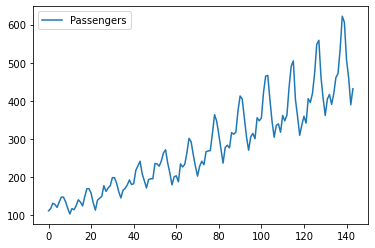

In [20]:
df.plot()

In [33]:
train_x, train_y, test_x, test_y, scaler,split_boundary = make_data(data)

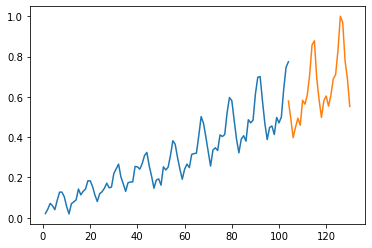

In [45]:
len(train_y)
plt.plot(np.arange(1, len(train_y)+1),train_y)
plt.plot(np.arange(len(train_y),len(train_y)+len(test_y)),test_y)
plt.show()

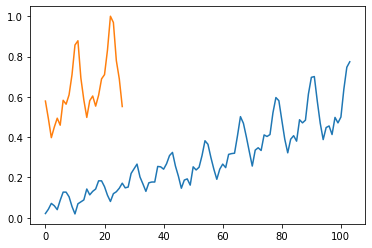

In [46]:
plt.plot(train_y)
plt.plot(test_y)
plt.show()

In [49]:
# шаг по данным для построения обучающих примеров
step = 1
xLen = 12



Тестовый пример, работают ли данные

In [52]:
input_1 = Input(shape=(train_x.shape[1:]))
z1 = Conv1D(24,6,padding = 'same')(input_1)
z1=MaxPooling1D(pool_size = 12,strides =1,padding = 'same')(z1)
z1 = Dropout(0.2)(z1)

x1 = LSTM(64, return_sequences="True")(z1)
x1 = Dropout(0.2)(x1)

x1=Flatten()(x1)
x1 = Dense(300,activation='relu')(x1)
x1 = Dropout(0.2)(x1)
x1 = Dense(100,activation='relu')(x1)
x1 = Dropout(0.2)(x1)
out=Dense(1)(x1)
model = Model(inputs = input_1,outputs = out,name = 'model')
model.compile(loss="mse", optimizer="adam", metrics=['mae'])
model.summary()
ww= model.get_weights()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 24)            168       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 12, 24)            0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 24)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 12, 64)            22784     
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 768)               0     

In [53]:
model.set_weights(ww)
history = model.fit(x=train_x,y=train_y, epochs=50,\
                       batch_size=256, validation_data=(test_x, test_y), verbose=1)


Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 0.1514 - mae: 0.3358 - val_loss: 0.2581 - val_mae: 0.4874
Epoch 2/50
1/1 [==============================] - 0s 18ms/step - loss: 0.0722 - mae: 0.2242 - val_loss: 0.0816 - val_mae: 0.2523
Epoch 3/50
1/1 [==============================] - 0s 20ms/step - loss: 0.0259 - mae: 0.1209 - val_loss: 0.0153 - val_mae: 0.1021
Epoch 4/50
1/1 [==============================] - 0s 20ms/step - loss: 0.0076 - mae: 0.0682 - val_loss: 0.0761 - val_mae: 0.2525
Epoch 5/50
1/1 [==============================] - 0s 20ms/step - loss: 0.0271 - mae: 0.1329 - val_loss: 0.0619 - val_mae: 0.2243
Epoch 6/50
1/1 [==============================] - 0s 20ms/step - loss: 0.0259 - mae: 0.1223 - val_loss: 0.0219 - val_mae: 0.1330
Epoch 7/50
1/1 [==============================] - 0s 21ms/step - loss: 0.0108 - mae: 0.0797 - val_loss: 0.0144 - val_mae: 0.0886
Epoch 8/50
1/1 [==============================] - 0s 19ms/step - loss: 0.0072 - mae: 0.0629 - val_l

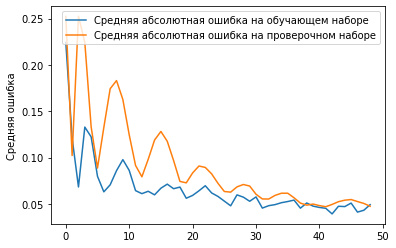

In [54]:
plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [55]:
predVal = model.predict(test_x).flatten()

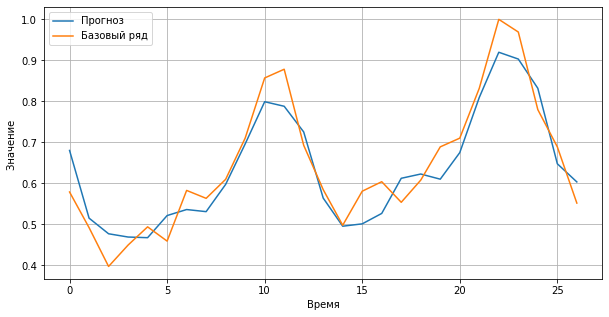

In [56]:

plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal, 
         label='Прогноз')
plt.plot(test_y, 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

сделаем подюоры по данной архитектуре

In [61]:
%%time
N=100
res_model = pd.DataFrame()
epochs = 50
batch_size = 256
xLen = [2,3,4,5,6,8,10,12]
con_n = [6,12,24,30,36,48,64,124]   
kern = [2,3,4,5,6,7,8,9,10,11,12]
ps = [2,3,4,5,6,7,8,9,10,11,12]
lstm_n = [12,24,36,48,60,72,80,100]
d_n_1 = [10,25,35,45,50,60,70,80,90,100,15,200,300,350,400,500]
act_1 = ['relu','relu','sigmoid','relu','relu','tanh','relu','relu']
dp=[0.1,0.15,0.2,0.2,0.3]


for i in range(N):
    param={}

    param['xLen'] = np.random.choice(xLen)
    param['con_n'] = np.random.choice(con_n)
    param['kern'] = int(np.random.choice(kern))
    param['ps'] = int(np.random.choice(ps))
    param['d_n_1'] = np.random.choice(d_n_1)
    param['d_n_2'] = np.random.choice(d_n_1)
    param['act_1'] = np.random.choice(act_1)
    param['act_2'] = np.random.choice(act_1)
    param['lstm_n'] = np.random.choice(lstm_n)
    param['dp'] = np.random.choice(dp)
    
    train_x, train_y, test_x, test_y, scaler,split_boundary = make_data(data,xLen= param['xLen'])
    
    
    
    input_1 = Input(shape=(train_x.shape[1:]))
    z1 = Conv1D(param['con_n'],param['kern'],padding = 'same')(input_1)
    z1=MaxPooling1D(pool_size = param['ps'],strides =1,padding = 'same')(z1)
    z1 = Dropout(param['dp'])(z1)

    x1 = LSTM(param['lstm_n'], return_sequences="True")(z1)
    x1 = Dropout(param['dp'])(x1)

    x1=Flatten()(x1)
    x1 = Dense(param['d_n_1'],activation=param['act_1'])(x1)
    x1 = Dropout(param['dp'])(x1)
    x1 = Dense(param['d_n_2'],activation=param['act_2'])(x1)
    x1 = Dropout(param['dp'])(x1)
    out=Dense(1)(x1)
    model = Model(inputs = input_1,outputs = out,name = f'model_{i}')
    model.compile(loss="mse", optimizer="adam", metrics=['mae'])

    ww= model.get_weights()
    res = testing(model,10)
    res['epochs'] = epochs
    res['model'] = model.name
    res['param'] = param
    res_model=res_model.append(res,ignore_index=True)
res_model.sort_values(by='res_mean',inplace=True)
res_model

Wall time: 18min 14s


,batch_size,epochs,model,param,res_max,res_mean,res_min,res_std,res_train_mean,time_iter
67,256.0,50.0,model_67,"{'xLen': 12, 'con_n': 30, 'kern': 7, 'ps': 2, ...",0.066971,0.058860,0.052514,0.004966,0.047561,1.070272
92,256.0,50.0,model_92,"{'xLen': 12, 'con_n': 64, 'kern': 12, 'ps': 5,...",0.078909,0.065367,0.050248,0.008250,0.050570,1.134631
56,256.0,50.0,model_56,"{'xLen': 12, 'con_n': 64, 'kern': 4, 'ps': 9, ...",0.079279,0.067121,0.061053,0.005283,0.048888,1.052661
4,256.0,50.0,model_4,"{'xLen': 10, 'con_n': 124, 'kern': 11, 'ps': 1...",0.077388,0.074535,0.071343,0.001775,0.051771,1.098298
59,256.0,50.0,model_59,"{'xLen': 12, 'con_n': 12, 'kern': 9, 'ps': 4, ...",0.081056,0.075097,0.070245,0.003116,0.055581,1.082265
...,...,...,...,...,...,...,...,...,...,...
50,256.0,50.0,model_50,"{'xLen': 3, 'con_n': 12, 'kern': 10, 'ps': 3, ...",0.354318,0.238803,0.162619,0.050036,0.139246,1.045651
32,256.0,50.0,model_32,"{'xLen': 3, 'con_n': 64, 'kern': 10, 'ps': 4, ...",0.284910,0.238830,0.203789,0.027902,0.121278,1.077980
10,256.0,50.0,model_10,"{'xLen': 4, 'con_n': 6, 'kern': 12, 'ps': 3, '...",0.327727,0.255779,0.160180,0.049594,0.165262,1.067671
47,256.0,50.0,model_47,"{'xLen': 8, 'con_n': 30, 'kern': 4, 'ps': 11, ...",0.398843,0.356796,0.305293,0.028281,0.318421,1.049509


Проверка лучшей модели по кол. эпох

In [64]:
res_model.iloc[0,3]

{'xLen': 12,
 'con_n': 30,
 'kern': 7,
 'ps': 2,
 'd_n_1': 300,
 'd_n_2': 35,
 'act_1': 'relu',
 'act_2': 'relu',
 'lstm_n': 60,
 'dp': 0.1}

In [66]:
%%time
param = res_model.iloc[0,3]

train_x, train_y, test_x, test_y, scaler,split_boundary = make_data(data,xLen= param['xLen'])
    
input_1 = Input(shape=(train_x.shape[1:]))
z1 = Conv1D(param['con_n'],param['kern'],padding = 'same')(input_1)
z1=MaxPooling1D(pool_size = param['ps'],strides =1,padding = 'same')(z1)
z1 = Dropout(param['dp'])(z1)

x1 = LSTM(param['lstm_n'], return_sequences="True")(z1)
x1 = Dropout(param['dp'])(x1)

x1=Flatten()(x1)
x1 = Dense(param['d_n_1'],activation=param['act_1'])(x1)
x1 = Dropout(param['dp'])(x1)
x1 = Dense(param['d_n_2'],activation=param['act_2'])(x1)
x1 = Dropout(param['dp'])(x1)
out=Dense(1)(x1)
model_best = Model(inputs = input_1,outputs = out,name = 'model_best')
model_best.compile(loss="mse", optimizer="adam", metrics=['mae'])

ww= model_best.get_weights()

for epochs in [35,70,100]: 
    res = testing(model_best,10)
    res['epochs'] = epochs
    res['model'] = model_best.name
    res['param'] = param
    res_model=res_model.append(res,ignore_index=True)
res_model.sort_values(by='res_mean',inplace=True)
res_model
    
    

Wall time: 39.4 s


,batch_size,epochs,model,param,res_max,res_mean,res_min,res_std,res_train_mean,time_iter
102,256.0,100.0,model_best,"{'xLen': 12, 'con_n': 30, 'kern': 7, 'ps': 2, ...",0.050397,0.043476,0.039419,0.003293,0.038198,1.811747
101,256.0,70.0,model_best,"{'xLen': 12, 'con_n': 30, 'kern': 7, 'ps': 2, ...",0.066865,0.053097,0.047294,0.005880,0.042770,1.266351
0,256.0,50.0,model_67,"{'xLen': 12, 'con_n': 30, 'kern': 7, 'ps': 2, ...",0.066971,0.058860,0.052514,0.004966,0.047561,1.070272
1,256.0,50.0,model_92,"{'xLen': 12, 'con_n': 64, 'kern': 12, 'ps': 5,...",0.078909,0.065367,0.050248,0.008250,0.050570,1.134631
2,256.0,50.0,model_56,"{'xLen': 12, 'con_n': 64, 'kern': 4, 'ps': 9, ...",0.079279,0.067121,0.061053,0.005283,0.048888,1.052661
...,...,...,...,...,...,...,...,...,...,...
95,256.0,50.0,model_50,"{'xLen': 3, 'con_n': 12, 'kern': 10, 'ps': 3, ...",0.354318,0.238803,0.162619,0.050036,0.139246,1.045651
96,256.0,50.0,model_32,"{'xLen': 3, 'con_n': 64, 'kern': 10, 'ps': 4, ...",0.284910,0.238830,0.203789,0.027902,0.121278,1.077980
97,256.0,50.0,model_10,"{'xLen': 4, 'con_n': 6, 'kern': 12, 'ps': 3, '...",0.327727,0.255779,0.160180,0.049594,0.165262,1.067671
98,256.0,50.0,model_47,"{'xLen': 8, 'con_n': 30, 'kern': 4, 'ps': 11, ...",0.398843,0.356796,0.305293,0.028281,0.318421,1.049509


In [70]:
res_model.iloc[0]

batch_size                                                      256
epochs                                                          100
model                                                    model_best
param             {'xLen': 12, 'con_n': 30, 'kern': 7, 'ps': 2, ...
res_max                                                   0.0503973
res_mean                                                  0.0434761
res_min                                                   0.0394193
res_std                                                   0.0032934
res_train_mean                                            0.0381982
time_iter                                                   1.81175
Name: 102, dtype: object

Обучим лучшую модель и посмотрим результаты

Epoch 1/75
4/4 [==============================] - 0s 16ms/step - loss: 0.0863 - mae: 0.2368 - val_loss: 0.0240 - val_mae: 0.1363
Epoch 2/75
4/4 [==============================] - 0s 10ms/step - loss: 0.0180 - mae: 0.1031 - val_loss: 0.0337 - val_mae: 0.1333
Epoch 3/75
4/4 [==============================] - 0s 10ms/step - loss: 0.0150 - mae: 0.0894 - val_loss: 0.0204 - val_mae: 0.1125
Epoch 4/75
4/4 [==============================] - 0s 10ms/step - loss: 0.0125 - mae: 0.0844 - val_loss: 0.0195 - val_mae: 0.1090
Epoch 5/75
4/4 [==============================] - 0s 10ms/step - loss: 0.0092 - mae: 0.0723 - val_loss: 0.0236 - val_mae: 0.1112
Epoch 6/75
4/4 [==============================] - 0s 11ms/step - loss: 0.0076 - mae: 0.0657 - val_loss: 0.0204 - val_mae: 0.1245
Epoch 7/75
4/4 [==============================] - 0s 10ms/step - loss: 0.0083 - mae: 0.0728 - val_loss: 0.0324 - val_mae: 0.1335
Epoch 8/75
4/4 [==============================] - 0s 10ms/step - loss: 0.0078 - mae: 0.0636 - val

4/4 [==============================] - 0s 11ms/step - loss: 0.0019 - mae: 0.0345 - val_loss: 0.0046 - val_mae: 0.0575
Epoch 65/75
4/4 [==============================] - 0s 11ms/step - loss: 0.0017 - mae: 0.0310 - val_loss: 0.0035 - val_mae: 0.0490
Epoch 66/75
4/4 [==============================] - 0s 11ms/step - loss: 0.0017 - mae: 0.0302 - val_loss: 0.0020 - val_mae: 0.0387
Epoch 67/75
4/4 [==============================] - 0s 11ms/step - loss: 0.0018 - mae: 0.0314 - val_loss: 0.0023 - val_mae: 0.0412
Epoch 68/75
4/4 [==============================] - 0s 11ms/step - loss: 0.0023 - mae: 0.0358 - val_loss: 0.0020 - val_mae: 0.0372
Epoch 69/75
4/4 [==============================] - 0s 11ms/step - loss: 0.0022 - mae: 0.0319 - val_loss: 0.0028 - val_mae: 0.0437
Epoch 70/75
4/4 [==============================] - 0s 11ms/step - loss: 0.0014 - mae: 0.0294 - val_loss: 0.0033 - val_mae: 0.0471
Epoch 71/75
4/4 [==============================] - 0s 10ms/step - loss: 0.0015 - mae: 0.0297 - val_los

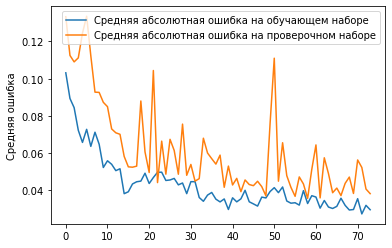

In [74]:
model_best.set_weights(ww)
history = model_best.fit(x=train_x,y=train_y, epochs=75,\
                       batch_size=None, validation_data=(test_x, test_y), verbose=1)
predVal = model_best.predict(test_x).flatten()
plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()


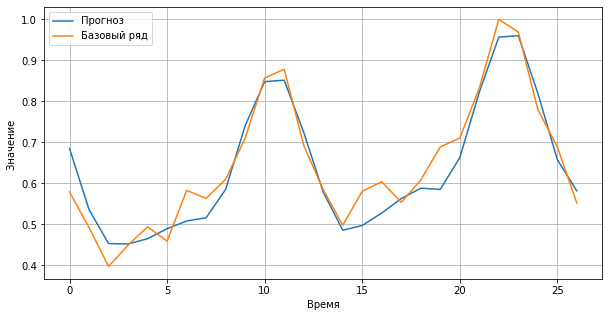

In [75]:
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal, 
         label='Прогноз')
plt.plot(test_y, 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

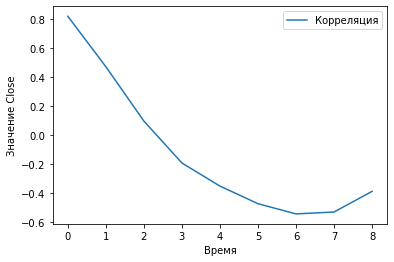

[0.8206368192339353,
 0.4723410058091467,
 0.09659879473692412,
 -0.19297254263850966,
 -0.3524757491628765,
 -0.4740939886994391,
 -0.5445831864515676,
 -0.5313157347171306,
 -0.3883260236183343]

In [76]:
print_corr(test_y,predVal)

Вме очень не стабилбно!!!!

Другой вариант сети

In [77]:
%%time
N=100

epochs = 50
batch_size = 512
xLen = [2,3,4,5,6,8,10,12]
step=[1,1,1,1,1,2]

lstm_n = [12,24,36,48,60,72,80,100,125,150]
d_n_1 = [10,25,35,45,50,60,70,80,90,100,15,200,300,350,400,500]
act_1 = ['relu','relu','softmax','relu','relu','tanh','relu','relu']
dp=[0.1,0.15,0.2,0.2,0.3]


for i in range(N):
    param={}
    param['xLen'] = np.random.choice(xLen)
    param['step'] = np.random.choice(step)
    param['d_n_1'] = np.random.choice(d_n_1)
    param['d_n_2'] = np.random.choice(d_n_1)
    param['act_1'] = np.random.choice(act_1)
    param['act_2'] = np.random.choice(act_1)
    param['lstm_n'] = np.random.choice(lstm_n)
    param['dp'] = np.random.choice(dp)
    
    
    train_x, train_y, test_x, test_y, scaler,split_boundary = make_data(data,xLen= param['xLen'])
    
    input_1 = Input(shape=(train_x.shape[1:]))


    x1 = LSTM(param['lstm_n'], return_sequences="True")(input_1)
    x1 = Dropout(param['dp'])(x1)

    x1=Flatten()(x1)
    x1 = Dense(param['d_n_1'],activation=param['act_1'])(x1)
    x1 = Dropout(param['dp'])(x1)
    x1 = Dense(param['d_n_2'],activation=param['act_2'])(x1)
    x1 = Dropout(param['dp'])(x1)
    out=Dense(1)(x1)
    model_2 = Model(inputs = input_1,outputs = out,name = f'model_2_{i}')
    model_2.compile(loss="mse", optimizer="adam", metrics=['mae'])

    ww= model_2.get_weights()
    res = testing(model_2,10)
    res['epochs'] = epochs
    res['model'] = model_2.name
    res['param'] = param
    res_model=res_model.append(res,ignore_index=True)
res_model.sort_values(by='res_mean',inplace=True)
res_model

Wall time: 17min 2s


,batch_size,epochs,model,param,res_max,res_mean,res_min,res_std,res_train_mean,time_iter
0,256.0,100.0,model_best,"{'xLen': 12, 'con_n': 30, 'kern': 7, 'ps': 2, ...",0.050397,0.043476,0.039419,0.003293,0.038198,1.811747
1,256.0,70.0,model_best,"{'xLen': 12, 'con_n': 30, 'kern': 7, 'ps': 2, ...",0.066865,0.053097,0.047294,0.005880,0.042770,1.266351
187,512.0,50.0,model_2_84,"{'xLen': 12, 'step': 1, 'd_n_1': 500, 'd_n_2':...",0.072952,0.056821,0.049444,0.006959,0.040188,1.009117
2,256.0,50.0,model_67,"{'xLen': 12, 'con_n': 30, 'kern': 7, 'ps': 2, ...",0.066971,0.058860,0.052514,0.004966,0.047561,1.070272
3,256.0,50.0,model_92,"{'xLen': 12, 'con_n': 64, 'kern': 12, 'ps': 5,...",0.078909,0.065367,0.050248,0.008250,0.050570,1.134631
...,...,...,...,...,...,...,...,...,...,...
143,512.0,50.0,model_2_40,"{'xLen': 4, 'step': 1, 'd_n_1': 25, 'd_n_2': 5...",0.543976,0.519782,0.477550,0.020956,0.174073,0.967279
174,512.0,50.0,model_2_71,"{'xLen': 6, 'step': 1, 'd_n_1': 10, 'd_n_2': 9...",0.531997,0.526507,0.513792,0.005123,0.178748,1.027034
161,512.0,50.0,model_2_58,"{'xLen': 6, 'step': 1, 'd_n_1': 50, 'd_n_2': 3...",0.554135,0.550085,0.547552,0.001672,0.190933,1.018300
126,512.0,50.0,model_2_23,"{'xLen': 5, 'step': 1, 'd_n_1': 300, 'd_n_2': ...",0.554956,0.551196,0.549989,0.001462,0.190088,0.988399


Возмем за основу model_2	. Так как xорошее среднее, минимальное значение res_max и res_std

In [78]:
res_model.iloc[2]

batch_size                                                      512
epochs                                                           50
model                                                    model_2_84
param             {'xLen': 12, 'step': 1, 'd_n_1': 500, 'd_n_2':...
res_max                                                   0.0729516
res_mean                                                  0.0568208
res_min                                                   0.0494445
res_std                                                  0.00695884
res_train_mean                                            0.0401885
time_iter                                                   1.00912
Name: 187, dtype: object

In [79]:
%%time
param = res_model.iloc[2,3]
param['xLen'] = np.random.choice(xLen)
param['step'] = np.random.choice(step)
param['d_n_1'] = np.random.choice(d_n_1)
param['d_n_2'] = np.random.choice(d_n_1)
param['act_1'] = np.random.choice(act_1)
param['act_2'] = np.random.choice(act_1)
param['lstm_n'] = np.random.choice(lstm_n)
param['dp'] = np.random.choice(dp)

    
train_x, train_y, test_x, test_y, scaler,split_boundary = make_data(data,xLen= param['xLen'])
    
input_1 = Input(shape=(train_x.shape[1:]))

x1 = LSTM(param['lstm_n'], return_sequences="True")(input_1)
x1 = Dropout(param['dp'])(x1)

x1=Flatten()(x1)
x1 = Dense(param['d_n_1'],activation=param['act_1'])(x1)
x1 = Dropout(param['dp'])(x1)
x1 = Dense(param['d_n_2'],activation=param['act_2'])(x1)
x1 = Dropout(param['dp'])(x1)
out=Dense(1)(x1)
model_2_best = Model(inputs = input_1,outputs = out,name = 'model_2_best')
model_2_best.compile(loss="mse", optimizer="adam", metrics=['mae'])
ww= model_2_best.get_weights()

for epochs in [30,70,100]:
    res = testing(model_2_best,50)
    res['epochs'] = epochs
    res['model'] = model_2_best.name
    res['param'] = param
    res_model=res_model.append(res,ignore_index=True)
res_model.sort_values(by='res_mean',inplace=True)
res_model
    

Wall time: 2min 47s


,batch_size,epochs,model,param,res_max,res_mean,res_min,res_std,res_train_mean,time_iter
0,256.0,100.0,model_best,"{'xLen': 12, 'con_n': 30, 'kern': 7, 'ps': 2, ...",0.050397,0.043476,0.039419,0.003293,0.038198,1.811747
1,256.0,70.0,model_best,"{'xLen': 12, 'con_n': 30, 'kern': 7, 'ps': 2, ...",0.066865,0.053097,0.047294,0.005880,0.042770,1.266351
2,512.0,50.0,model_2_84,"{'xLen': 5, 'step': 1, 'd_n_1': 100, 'd_n_2': ...",0.072952,0.056821,0.049444,0.006959,0.040188,1.009117
3,256.0,50.0,model_67,"{'xLen': 12, 'con_n': 30, 'kern': 7, 'ps': 2, ...",0.066971,0.058860,0.052514,0.004966,0.047561,1.070272
4,256.0,50.0,model_92,"{'xLen': 12, 'con_n': 64, 'kern': 12, 'ps': 5,...",0.078909,0.065367,0.050248,0.008250,0.050570,1.134631
...,...,...,...,...,...,...,...,...,...,...
198,512.0,50.0,model_2_40,"{'xLen': 4, 'step': 1, 'd_n_1': 25, 'd_n_2': 5...",0.543976,0.519782,0.477550,0.020956,0.174073,0.967279
199,512.0,50.0,model_2_71,"{'xLen': 6, 'step': 1, 'd_n_1': 10, 'd_n_2': 9...",0.531997,0.526507,0.513792,0.005123,0.178748,1.027034
200,512.0,50.0,model_2_58,"{'xLen': 6, 'step': 1, 'd_n_1': 50, 'd_n_2': 3...",0.554135,0.550085,0.547552,0.001672,0.190933,1.018300
201,512.0,50.0,model_2_23,"{'xLen': 5, 'step': 1, 'd_n_1': 300, 'd_n_2': ...",0.554956,0.551196,0.549989,0.001462,0.190088,0.988399


In [80]:
res_model[res_model.model=='model_2_best']

,batch_size,epochs,model,param,res_max,res_mean,res_min,res_std,res_train_mean,time_iter
205,512.0,100.0,model_2_best,"{'xLen': 5, 'step': 1, 'd_n_1': 100, 'd_n_2': ...",0.135334,0.128010,0.119990,0.003549,0.064587,1.623336
204,512.0,70.0,model_2_best,"{'xLen': 5, 'step': 1, 'd_n_1': 100, 'd_n_2': ...",0.149210,0.143382,0.136611,0.002082,0.071955,1.161836
203,512.0,30.0,model_2_best,"{'xLen': 5, 'step': 1, 'd_n_1': 100, 'd_n_2': ...",0.204754,0.193762,0.149687,0.008919,0.084418,0.560341


Epoch 1/45
4/4 [==============================] - 0s 15ms/step - loss: 0.0961 - mae: 0.2600 - val_loss: 0.3045 - val_mae: 0.5305
Epoch 2/45
4/4 [==============================] - 0s 8ms/step - loss: 0.0527 - mae: 0.1799 - val_loss: 0.0933 - val_mae: 0.2613
Epoch 3/45
4/4 [==============================] - 0s 8ms/step - loss: 0.0193 - mae: 0.1058 - val_loss: 0.0383 - val_mae: 0.1622
Epoch 4/45
4/4 [==============================] - 0s 9ms/step - loss: 0.0218 - mae: 0.1165 - val_loss: 0.0423 - val_mae: 0.1638
Epoch 5/45
4/4 [==============================] - 0s 9ms/step - loss: 0.0129 - mae: 0.0826 - val_loss: 0.0839 - val_mae: 0.2445
Epoch 6/45
4/4 [==============================] - 0s 10ms/step - loss: 0.0146 - mae: 0.0874 - val_loss: 0.0578 - val_mae: 0.1952
Epoch 7/45
4/4 [==============================] - 0s 9ms/step - loss: 0.0110 - mae: 0.0770 - val_loss: 0.0313 - val_mae: 0.1458
Epoch 8/45
4/4 [==============================] - 0s 9ms/step - loss: 0.0130 - mae: 0.0900 - val_loss:

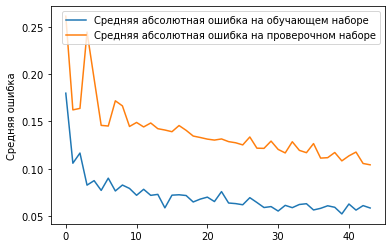

In [81]:
# Обучим лучшую модель
model_2_best.set_weights(ww)
history = model_2_best.fit(x=train_x,y=train_y, epochs=45,\
                       batch_size=None, validation_data=(test_x, test_y), verbose=1)
predVal = model_2_best.predict(test_x).flatten()
plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

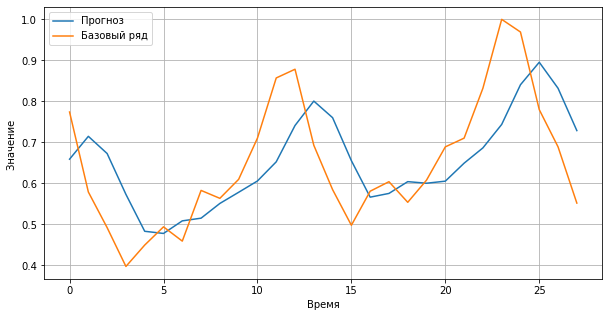

In [82]:
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal, 
         label='Прогноз')
plt.plot(test_y, 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

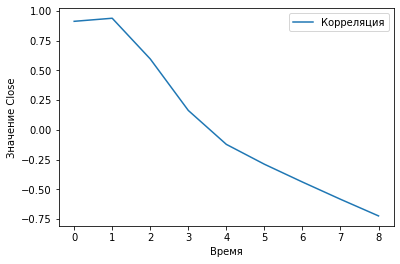

[0.9121651253757037,
 0.9380408486716968,
 0.5957380970875972,
 0.16274925655759753,
 -0.12248012962243435,
 -0.2893884593042679,
 -0.43904980491942364,
 -0.5839907210042713,
 -0.7240387637953382]

In [83]:
print_corr(test_y,predVal)

Второй вариант явно хуже первого

третий вариант модели

In [85]:
%%time
N=100
# res_model = pd.DataFrame()
epochs = 50
batch_size = 512
xLen = [2,3,4,5,6,8,10,12]
step=[1,1,1,1,1,2]

lstm_n = [12,24,36,48,60,72,80,100,125,150]
d_n_1 = [10,25,35,45,50,60,70,80,90,100,15,200,300,350,400,500]
act_1 = ['relu','relu','sigmoid','relu','relu','tanh','relu','relu']
dp=[0.1,0.15,0.2,0.2,0.3]


for i in range(N):
    param={}

    param['xLen'] = np.random.choice(xLen)
    param['step'] = np.random.choice(step)
    param['d_n_1'] = np.random.choice(d_n_1)
    param['d_n_2'] = np.random.choice(d_n_1)
    param['act_1'] = np.random.choice(act_1)
    param['act_2'] = np.random.choice(act_1)
    param['lstm_n'] = np.random.choice(lstm_n)
    param['dp'] = np.random.choice(dp)
    param['d_n_3'] = np.random.choice(d_n_1)
    param['act_3'] = np.random.choice(act_1)
    
    
    train_x, train_y, test_x, test_y, scaler,split_boundary = make_data(data,xLen= param['xLen'])
    
    input_1 = Input(shape=(train_x.shape[1:]))
    z1 = Dense(param['d_n_3'],activation=param['act_3'])(input_1)
    z1 = Dense(train_x.shape[1])(z1)

    x1 = LSTM(param['lstm_n'], return_sequences="True")(z1)
    x1 = Dropout(param['dp'])(x1)

    x1=Flatten()(x1)
    x1 = Dense(param['d_n_1'],activation=param['act_1'])(x1)
    x1 = Dropout(param['dp'])(x1)
    x1 = Dense(param['d_n_2'],activation=param['act_2'])(x1)
    x1 = Dropout(param['dp'])(x1)
    out=Dense(1)(x1)
    model_3 = Model(inputs = input_1,outputs = out,name = f'model_3_{i}')
    model_3.compile(loss="mse", optimizer="adam", metrics=['mae'])

    ww= model_3.get_weights()
    res = testing(model_3,10)
    res['epochs'] = epochs
    res['model'] = model_3.name
    res['param'] = param
    res_model=res_model.append(res,ignore_index=True)
res_model.sort_values(by='res_mean',inplace=True)
res_model

Wall time: 18min 46s


,batch_size,epochs,model,param,res_max,res_mean,res_min,res_std,res_train_mean,time_iter
0,256.0,100.0,model_best,"{'xLen': 12, 'con_n': 30, 'kern': 7, 'ps': 2, ...",0.050397,0.043476,0.039419,0.003293,0.038198,1.811747
1,256.0,70.0,model_best,"{'xLen': 12, 'con_n': 30, 'kern': 7, 'ps': 2, ...",0.066865,0.053097,0.047294,0.005880,0.042770,1.266351
2,512.0,50.0,model_2_84,"{'xLen': 5, 'step': 1, 'd_n_1': 100, 'd_n_2': ...",0.072952,0.056821,0.049444,0.006959,0.040188,1.009117
3,256.0,50.0,model_67,"{'xLen': 12, 'con_n': 30, 'kern': 7, 'ps': 2, ...",0.066971,0.058860,0.052514,0.004966,0.047561,1.070272
4,256.0,50.0,model_92,"{'xLen': 12, 'con_n': 64, 'kern': 12, 'ps': 5,...",0.078909,0.065367,0.050248,0.008250,0.050570,1.134631
...,...,...,...,...,...,...,...,...,...,...
201,512.0,50.0,model_2_40,"{'xLen': 4, 'step': 1, 'd_n_1': 25, 'd_n_2': 5...",0.543976,0.519782,0.477550,0.020956,0.174073,0.967279
202,512.0,50.0,model_2_71,"{'xLen': 6, 'step': 1, 'd_n_1': 10, 'd_n_2': 9...",0.531997,0.526507,0.513792,0.005123,0.178748,1.027034
203,512.0,50.0,model_2_58,"{'xLen': 6, 'step': 1, 'd_n_1': 50, 'd_n_2': 3...",0.554135,0.550085,0.547552,0.001672,0.190933,1.018300
204,512.0,50.0,model_2_23,"{'xLen': 5, 'step': 1, 'd_n_1': 300, 'd_n_2': ...",0.554956,0.551196,0.549989,0.001462,0.190088,0.988399


Посмотрим на лучшую третью модель

In [91]:
res_model[res_model.model.str.contains('model_3_')]

,batch_size,epochs,model,param,res_max,res_mean,res_min,res_std,res_train_mean,time_iter
11,512.0,50.0,model_3_82,"{'xLen': 12, 'step': 1, 'd_n_1': 100, 'd_n_2':...",0.085142,0.079571,0.073621,0.004099,0.062123,1.167061
14,512.0,50.0,model_3_80,"{'xLen': 12, 'step': 1, 'd_n_1': 350, 'd_n_2':...",0.090888,0.083320,0.069069,0.006163,0.049613,1.223913
17,512.0,50.0,model_3_97,"{'xLen': 12, 'step': 2, 'd_n_1': 500, 'd_n_2':...",0.089547,0.083649,0.080305,0.002489,0.053147,1.167195
22,512.0,50.0,model_3_62,"{'xLen': 12, 'step': 1, 'd_n_1': 90, 'd_n_2': ...",0.093047,0.086965,0.084878,0.002345,0.057610,1.109409
27,512.0,50.0,model_3_38,"{'xLen': 12, 'step': 2, 'd_n_1': 60, 'd_n_2': ...",0.091245,0.088147,0.085333,0.001600,0.061485,1.095796
...,...,...,...,...,...,...,...,...,...,...
286,512.0,50.0,model_3_27,"{'xLen': 2, 'step': 1, 'd_n_1': 300, 'd_n_2': ...",0.388604,0.384251,0.381261,0.002160,0.142524,1.086788
287,512.0,50.0,model_3_55,"{'xLen': 8, 'step': 1, 'd_n_1': 350, 'd_n_2': ...",0.437305,0.391280,0.371830,0.019247,0.178046,1.070179
289,512.0,50.0,model_3_57,"{'xLen': 6, 'step': 1, 'd_n_1': 70, 'd_n_2': 4...",0.437576,0.395944,0.320750,0.032047,0.257811,1.096565
292,512.0,50.0,model_3_6,"{'xLen': 2, 'step': 1, 'd_n_1': 350, 'd_n_2': ...",0.473371,0.410953,0.375207,0.027021,0.146415,1.037742


In [93]:
res_model.loc[11]

batch_size                                                      512
epochs                                                           50
model                                                    model_3_82
param             {'xLen': 12, 'step': 1, 'd_n_1': 100, 'd_n_2':...
res_max                                                   0.0851421
res_mean                                                   0.079571
res_min                                                   0.0736207
res_std                                                  0.00409912
res_train_mean                                            0.0621231
time_iter                                                   1.16706
Name: 11, dtype: object

Epoch 1/70
1/1 [==============================] - 2s 2s/step - loss: 0.1407 - mae: 0.3224 - val_loss: 0.2341 - val_mae: 0.4609
Epoch 2/70
1/1 [==============================] - 0s 22ms/step - loss: 0.0609 - mae: 0.2039 - val_loss: 0.0694 - val_mae: 0.2234
Epoch 3/70
1/1 [==============================] - 0s 21ms/step - loss: 0.0214 - mae: 0.1055 - val_loss: 0.0206 - val_mae: 0.1264
Epoch 4/70
1/1 [==============================] - 0s 21ms/step - loss: 0.0144 - mae: 0.0903 - val_loss: 0.0616 - val_mae: 0.2245
Epoch 5/70
1/1 [==============================] - 0s 21ms/step - loss: 0.0411 - mae: 0.1538 - val_loss: 0.0368 - val_mae: 0.1747
Epoch 6/70
1/1 [==============================] - 0s 22ms/step - loss: 0.0198 - mae: 0.1125 - val_loss: 0.0183 - val_mae: 0.1138
Epoch 7/70
1/1 [==============================] - 0s 21ms/step - loss: 0.0147 - mae: 0.0892 - val_loss: 0.0265 - val_mae: 0.1174
Epoch 8/70
1/1 [==============================] - 0s 22ms/step - loss: 0.0121 - mae: 0.0838 - val_l

1/1 [==============================] - 0s 22ms/step - loss: 0.0065 - mae: 0.0545 - val_loss: 0.0076 - val_mae: 0.0617
Epoch 65/70
1/1 [==============================] - 0s 21ms/step - loss: 0.0063 - mae: 0.0556 - val_loss: 0.0073 - val_mae: 0.0607
Epoch 66/70
1/1 [==============================] - 0s 22ms/step - loss: 0.0056 - mae: 0.0544 - val_loss: 0.0069 - val_mae: 0.0599
Epoch 67/70
1/1 [==============================] - 0s 21ms/step - loss: 0.0052 - mae: 0.0500 - val_loss: 0.0067 - val_mae: 0.0590
Epoch 68/70
1/1 [==============================] - 0s 21ms/step - loss: 0.0061 - mae: 0.0538 - val_loss: 0.0065 - val_mae: 0.0579
Epoch 69/70
1/1 [==============================] - 0s 22ms/step - loss: 0.0050 - mae: 0.0524 - val_loss: 0.0068 - val_mae: 0.0581
Epoch 70/70
1/1 [==============================] - 0s 20ms/step - loss: 0.0057 - mae: 0.0535 - val_loss: 0.0074 - val_mae: 0.0612


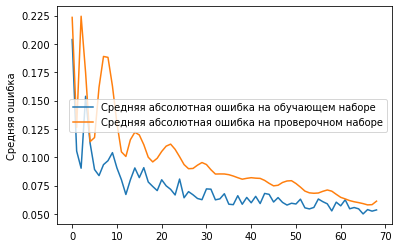

In [98]:
param = res_model.loc[11,'param']
train_x, train_y, test_x, test_y, scaler,split_boundary = make_data(data,xLen= param['xLen'])

input_1 = Input(shape=(train_x.shape[1:]))
z1 = Dense(param['d_n_3'],activation=param['act_3'])(input_1)
z1 = Dense(train_x.shape[1])(z1)

x1 = LSTM(param['lstm_n'], return_sequences="True")(z1)
x1 = Dropout(param['dp'])(x1)

x1=Flatten()(x1)
x1 = Dense(param['d_n_1'],activation=param['act_1'])(x1)
x1 = Dropout(param['dp'])(x1)
x1 = Dense(param['d_n_2'],activation=param['act_2'])(x1)
x1 = Dropout(param['dp'])(x1)
out=Dense(1)(x1)
model_3_best = Model(inputs = input_1,outputs = out,name = 'model_3_best')
model_3_best.compile(loss="mse", optimizer="adam", metrics=['mae'])


history = model_3_best.fit(x=train_x,y=train_y, epochs=70,\
                       batch_size=512, validation_data=(test_x, test_y), verbose=1)
predVal = model_3_best.predict(test_x).flatten()
plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

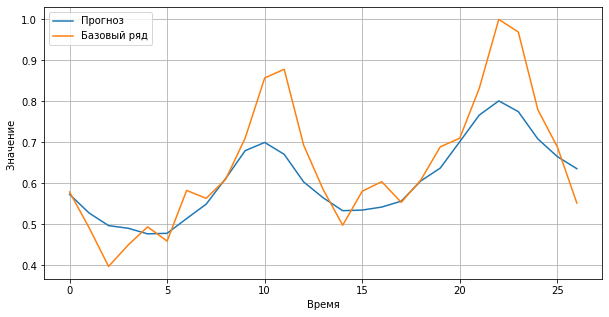

In [99]:
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal, 
         label='Прогноз')
plt.plot(test_y, 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

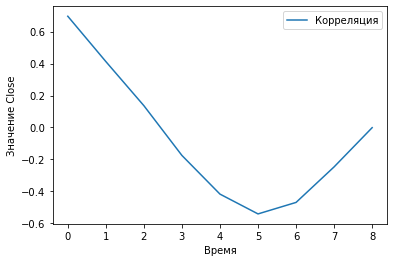

[0.6965320407574422,
 0.41280540593140047,
 0.136356962937952,
 -0.1753387405095478,
 -0.41746854722016824,
 -0.5415221938013003,
 -0.46948872740223,
 -0.2468486944956874,
 -0.001293520677348026]

In [100]:
print_corr(test_y,predVal)

Третья модель лучше второй, но хуже первой

А теперь самую простую модель

In [86]:
%%time
N=100
# res_model = pd.DataFrame()
epochs = 35
batch_size = 512
xLen = [2,3,4,5,6,8,10,12]
step=[1,1,1,1,1,2]

lstm_n = [12,24,36,48,60,72,80,100,125,150]

dp=[0.1,0.15,0.2,0.2,0.3]


for i in range(N):
    param={}
    param['xLen'] = np.random.choice(xLen)
    param['step'] = np.random.choice(step)
    param['lstm_n'] = np.random.choice(lstm_n)
    param['lstm_n_1'] = np.random.choice(lstm_n)
    param['dp'] = np.random.choice(dp)

    
    
    train_x, train_y, test_x, test_y, scaler,split_boundary = make_data(data,xLen= param['xLen'])
    
    input_1 = Input(shape=(train_x.shape[1:]))

    x1 = LSTM(param['lstm_n'], return_sequences="True")(input_1)
    x1 = Dropout(param['dp'])(x1)
    x1 = LSTM(param['lstm_n'], return_sequences="False")(x1)
    x1 = Dropout(param['dp'])(x1)
    x1=Flatten()(x1)
    out=Dense(1)(x1)
    model_4 = Model(inputs = input_1,outputs = out,name = f'model_4_{i}')
    model_4.compile(loss="mse", optimizer="adam", metrics=['mae'])

    ww= model_4.get_weights()
    res = testing(model_4,10)
    res['epochs'] = epochs
    res['model'] = model_4.name
    res['param'] = param
    res_model=res_model.append(res,ignore_index=True)
res_model.sort_values(by='res_mean',inplace=True)
res_model

Wall time: 16min 25s


,batch_size,epochs,model,param,res_max,res_mean,res_min,res_std,res_train_mean,time_iter
0,256.0,100.0,model_best,"{'xLen': 12, 'con_n': 30, 'kern': 7, 'ps': 2, ...",0.050397,0.043476,0.039419,0.003293,0.038198,1.811747
1,256.0,70.0,model_best,"{'xLen': 12, 'con_n': 30, 'kern': 7, 'ps': 2, ...",0.066865,0.053097,0.047294,0.005880,0.042770,1.266351
2,512.0,50.0,model_2_84,"{'xLen': 5, 'step': 1, 'd_n_1': 100, 'd_n_2': ...",0.072952,0.056821,0.049444,0.006959,0.040188,1.009117
3,256.0,50.0,model_67,"{'xLen': 12, 'con_n': 30, 'kern': 7, 'ps': 2, ...",0.066971,0.058860,0.052514,0.004966,0.047561,1.070272
4,256.0,50.0,model_92,"{'xLen': 12, 'con_n': 64, 'kern': 12, 'ps': 5,...",0.078909,0.065367,0.050248,0.008250,0.050570,1.134631
...,...,...,...,...,...,...,...,...,...,...
335,512.0,35.0,model_4_29,"{'xLen': 2, 'step': 1, 'lstm_n': 12, 'lstm_n_1...",0.525379,0.521756,0.520556,0.001296,0.172230,0.912029
302,512.0,50.0,model_2_71,"{'xLen': 6, 'step': 1, 'd_n_1': 10, 'd_n_2': 9...",0.531997,0.526507,0.513792,0.005123,0.178748,1.027034
303,512.0,50.0,model_2_58,"{'xLen': 6, 'step': 1, 'd_n_1': 50, 'd_n_2': 3...",0.554135,0.550085,0.547552,0.001672,0.190933,1.018300
304,512.0,50.0,model_2_23,"{'xLen': 5, 'step': 1, 'd_n_1': 300, 'd_n_2': ...",0.554956,0.551196,0.549989,0.001462,0.190088,0.988399


In [101]:
res_model[res_model.model.str.contains('model_4_')]

,batch_size,epochs,model,param,res_max,res_mean,res_min,res_std,res_train_mean,time_iter
341,512.0,35.0,model_4_35,"{'xLen': 12, 'step': 1, 'lstm_n': 60, 'lstm_n_...",0.107503,0.105569,0.101485,0.001516,0.064928,0.932292
316,512.0,35.0,model_4_10,"{'xLen': 12, 'step': 2, 'lstm_n': 60, 'lstm_n_...",0.122031,0.106185,0.102915,0.006069,0.067199,0.967479
353,512.0,35.0,model_4_47,"{'xLen': 12, 'step': 2, 'lstm_n': 125, 'lstm_n...",0.113723,0.110547,0.102190,0.003081,0.057737,1.036487
385,512.0,35.0,model_4_79,"{'xLen': 12, 'step': 1, 'lstm_n': 100, 'lstm_n...",0.116844,0.110951,0.103989,0.003267,0.071081,1.019428
358,512.0,35.0,model_4_52,"{'xLen': 12, 'step': 1, 'lstm_n': 150, 'lstm_n...",0.115836,0.111166,0.105324,0.003645,0.060650,1.037843
...,...,...,...,...,...,...,...,...,...,...
343,512.0,35.0,model_4_37,"{'xLen': 2, 'step': 1, 'lstm_n': 24, 'lstm_n_1...",0.409301,0.405816,0.401184,0.002804,0.129822,0.907324
404,512.0,35.0,model_4_98,"{'xLen': 2, 'step': 1, 'lstm_n': 24, 'lstm_n_1...",0.434577,0.429812,0.420809,0.004510,0.136669,0.861383
391,512.0,35.0,model_4_85,"{'xLen': 5, 'step': 1, 'lstm_n': 12, 'lstm_n_1...",0.460780,0.432930,0.406920,0.015465,0.143482,0.946561
329,512.0,35.0,model_4_23,"{'xLen': 3, 'step': 1, 'lstm_n': 12, 'lstm_n_1...",0.482688,0.479832,0.473633,0.002801,0.162008,0.927844


In [102]:
res_model.loc[341]

batch_size                                                      512
epochs                                                           35
model                                                    model_4_35
param             {'xLen': 12, 'step': 1, 'lstm_n': 60, 'lstm_n_...
res_max                                                    0.107503
res_mean                                                   0.105569
res_min                                                    0.101485
res_std                                                  0.00151634
res_train_mean                                            0.0649276
time_iter                                                  0.932292
Name: 341, dtype: object

Посмотрим на лучшую модель

Epoch 1/35
1/1 [==============================] - 3s 3s/step - loss: 0.1343 - mae: 0.3159 - val_loss: 0.3178 - val_mae: 0.5433
Epoch 2/35
1/1 [==============================] - 0s 22ms/step - loss: 0.0773 - mae: 0.2281 - val_loss: 0.1868 - val_mae: 0.4073
Epoch 3/35
1/1 [==============================] - 0s 22ms/step - loss: 0.0402 - mae: 0.1531 - val_loss: 0.0763 - val_mae: 0.2394
Epoch 4/35
1/1 [==============================] - 0s 21ms/step - loss: 0.0155 - mae: 0.0898 - val_loss: 0.0265 - val_mae: 0.1171
Epoch 5/35
1/1 [==============================] - 0s 23ms/step - loss: 0.0107 - mae: 0.0848 - val_loss: 0.0348 - val_mae: 0.1378
Epoch 6/35
1/1 [==============================] - 0s 22ms/step - loss: 0.0089 - mae: 0.0720 - val_loss: 0.0232 - val_mae: 0.1090
Epoch 7/35
1/1 [==============================] - 0s 22ms/step - loss: 0.0091 - mae: 0.0769 - val_loss: 0.0260 - val_mae: 0.1157
Epoch 8/35
1/1 [==============================] - 0s 23ms/step - loss: 0.0086 - mae: 0.0714 - val_l

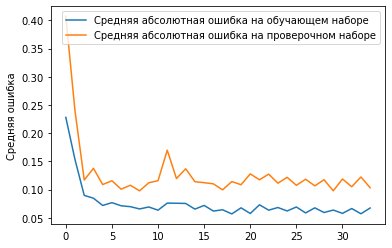

In [105]:
param = res_model.loc[341,'param']

train_x, train_y, test_x, test_y, scaler,split_boundary = make_data(data,xLen= param['xLen'])

input_1 = Input(shape=(train_x.shape[1:]))

x1 = LSTM(param['lstm_n'], return_sequences="True")(input_1)
x1 = Dropout(param['dp'])(x1)
x1 = LSTM(param['lstm_n'], return_sequences="False")(x1)
x1 = Dropout(param['dp'])(x1)
x1=Flatten()(x1)
out=Dense(1)(x1)
model_4_best = Model(inputs = input_1,outputs = out,name = 'model_4_best')
model_4_best.compile(loss="mse", optimizer="rmsprop", metrics=['mae'])



history = model_4_best.fit(x=train_x,y=train_y, epochs=35,\
                       batch_size=512, validation_data=(test_x, test_y), verbose=1)
predVal = model_4_best.predict(test_x).flatten()
plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

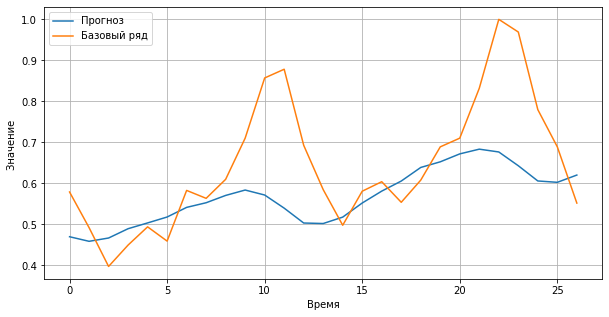

In [106]:
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal, 
         label='Прогноз')
plt.plot(test_y, 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

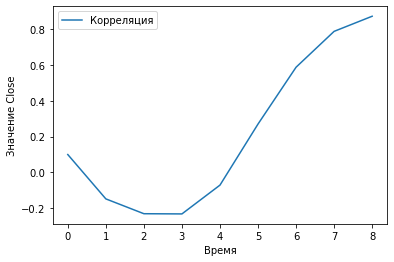

[0.09970213941889111,
 -0.14845974478729307,
 -0.2314630360965713,
 -0.2325956406698957,
 -0.07137439495204354,
 0.2704313165945502,
 0.5884640309587245,
 0.7892042639394143,
 0.8737875519814863]

In [107]:
print_corr(test_y,predVal)